# ITD from sound stimuli using coincedence detection

In this notebook we will model the cochlear neuron responses (phase locked) to a sound stimulus and model ITD selection with a coincedence detection neuron.

First, we create a sound wave.

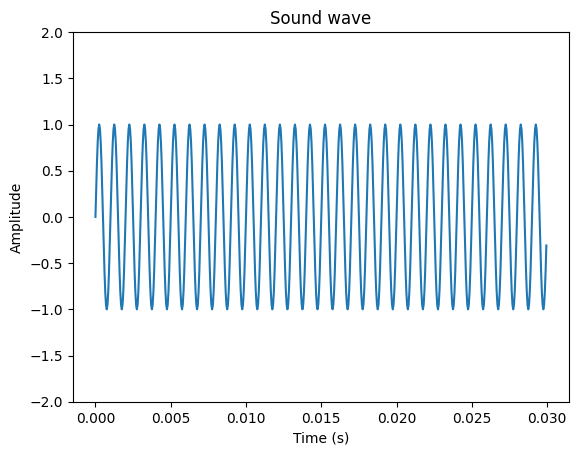

In [23]:
import numpy as np
from scipy.signal import butter, lfilter
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# -----------------------------
# 1. Sound stimulus
# -----------------------------
fs = 20000  # sampling rate (Hz)
T = 0.03  # duration (s)
t = np.arange(0, T, 1 / fs)

freq = 1000  # tone frequency (Hz)
sound = np.sin(2 * np.pi * freq * t)

#plot sound
plt.plot(t, sound)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sound wave')
plt.margins(y=0.5)
plt.show()

The ITD is the difference in arrival time between the two ears.

$$ ITD = \frac{d}{c} \sin(\theta)$$

Where:
- $d$ is the distance between the ears (approximately 8 cm for a barn owl)
- $c$ is the speed of sound (approximately 343 m/s at 20°C)
- $\theta$ is the angle of arrival (positive for sound coming from the right, negative for sound coming from the left)

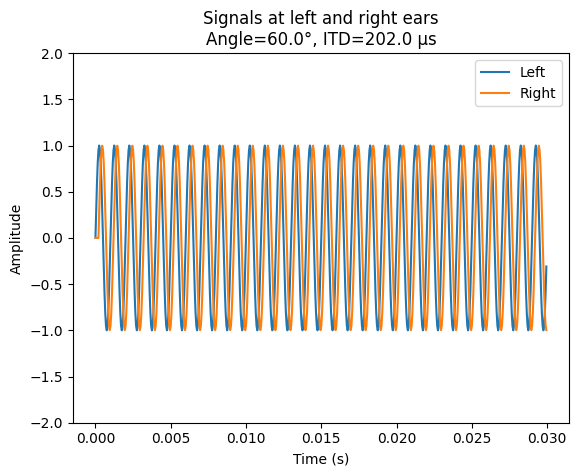

In [24]:
# -----------------------------
# 2. Compute ITD from angle
# -----------------------------
theta_deg = 60.0  # sound angle
theta = np.deg2rad(theta_deg)

owl_head_width = 0.08  # head width (m)
speed_of_sound = 343.0  # speed of sound (m/s)

itd = (owl_head_width / speed_of_sound) * np.sin(theta)  # seconds
# print(f"ITD = {itd*1e6:.1f} us")


# -----------------------------
# 3. Apply ITD (fractional delay)
# -----------------------------
def fractional_delay(signal, delay, fs):
    t = np.arange(len(signal)) / fs
    f = interp1d(t, signal, bounds_error=False, fill_value=0.0)
    return f(t - delay)


left_signal = sound
right_signal = fractional_delay(sound, itd, fs)

#plot left and right signals
plt.figure()
plt.plot(t, left_signal, label="Left")
plt.plot(t, right_signal, label="Right")
plt.margins(y=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title(f"Signals at left and right ears\nAngle={theta_deg}°, ITD={itd*1e6:.1f} µs")
plt.show()

The above plot shows left and right signals with phase offset by the ITD.

Next we apply a filter to the sound wave to isolate the frequency range of interest. This is essentially the tuning curve of the auditory nerve fiber in the frequency domain.

Aside: when I started working on this, I thought we may be able to isolate a frequency range simply by applying a Fourier transform to the signal, multiplying by a indicator function (1 on the frequency range we want, and 0 otherwise), then taking the inverse Fourier transform. However, doing so is not representative of a *causal* filter, which is required for real-time processing. Such an ideal "brick-wall" filter would be equivalent to a convolution of the signal with a sinc function extended infinitely in time, hense non-causal. We choose to model the auditory nerve fiber's frequency tuning curve using a causal filter because it realistically captures the temporal dynamics of auditory processing.

The Butterworth bandpass filter is a good choice for this application because it has a maximally flat frequency response in the passband, which means it preserves the shape of the sound wave while attenuating frequencies outside the passband, all while maintaining causality.


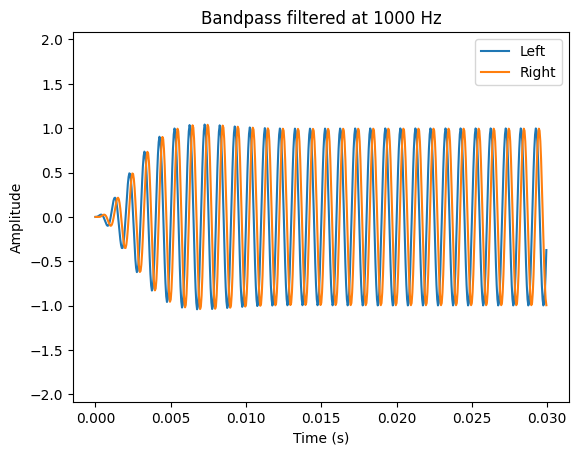

In [25]:
# -----------------------------
# 4. Simple cochlear bandpass filter 
# -----------------------------
def bandpass(signal, fs, f_center, bw=200):
    low = (f_center - bw / 2) / (fs / 2)
    high = (f_center + bw / 2) / (fs / 2)
    b, a = butter(2, [low, high], btype="band")
    return lfilter(b, a, signal)


left_filt = bandpass(left_signal, fs, freq)
right_filt = bandpass(right_signal, fs, freq)

# plot filtered signals
plt.figure()
plt.plot(t, left_filt, label="Left")
plt.plot(t, right_filt, label="Right")
plt.margins(y=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title(f"Bandpass filtered at {freq} Hz")
plt.show()

The above signal is the relevant part of our sound stimulus for the neuron response. Next, we generate spike responses of left/right neurons by thresholding the signal. The neurons spike when the signal crosses a certain threshold in the preferred direction (here, increasing amplitude).



Left spikes:  12
Right spikes: 12


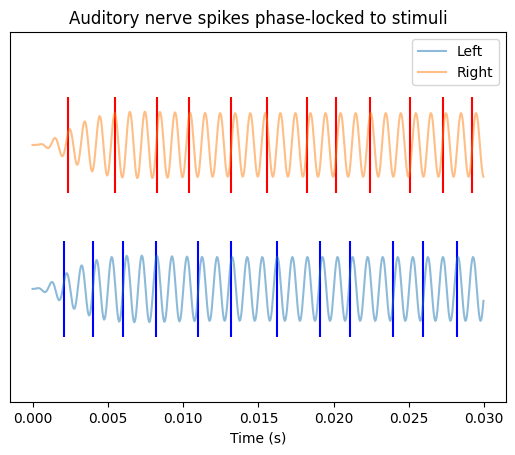

In [26]:
# -----------------------------
# 5. Auditory nerve spike generator
# -----------------------------
def auditory_nerve_spikes(
    signal, fs, threshold=0.3, jitter_std=100e-6, refractory=2e-3
):
    """
    Phase-locking via upward threshold crossings
    """
    spikes = []
    last_spike_time = -np.inf

    for i in range(1, len(signal)):
        if signal[i - 1] < threshold and signal[i] >= threshold:
            spike_time = i / fs
            if spike_time - last_spike_time >= refractory:
                spike_time += np.random.normal(0, jitter_std)
                spikes.append(spike_time)
                last_spike_time = spike_time

    return np.array(spikes)

auditory_arp = 0.002 # absolute refractory period, seconds
left_spikes = auditory_nerve_spikes(left_filt, fs, refractory=auditory_arp)
right_spikes = auditory_nerve_spikes(right_filt, fs, refractory=auditory_arp)

# -----------------------------
# 6. Inspect results
# -----------------------------
print(f"Left spikes:  {len(left_spikes)}")
print(f"Right spikes: {len(right_spikes)}")

# raster plot of left and right spikes
plt.figure()
plt.eventplot([left_spikes, right_spikes], colors=["b", "r"], lineoffsets=1.5)
plt.plot(t, left_filt/3, label="Left", alpha=0.5)
plt.plot(t, right_filt/3+1.5, label="Right", alpha=0.5)
plt.xlabel("Time (s)")
plt.legend()
plt.title("Auditory nerve spikes phase-locked to stimuli")
plt.yticks([])
plt.show()

Above we see the left and right auditory nerve spikes overlayed on their respective filtered signals.
Note that, depending on refractory period, some slopes may be missed. This will cause noise downstream.

The following function applies the Jeffress model to simulate auditory processing: the function takes in left and right auditory nerve spikes and returns coincidence spikes subject to a coincidence window. There is also a delay parameter, which corresponds to the ITD tuning of the coincidence detector neuron.

In [27]:
def itd_tuned_neuron(left_spikes, right_spikes, delay, coincidence_window=0.001):
    """
    ITD-tuned coincidence detector with axonal delay.

    Parameters
    ----------
    left_spikes : array-like
        Spike times from left ear
    right_spikes : array-like
        Spike times from right ear
    delay : float
        Axonal delay applied to left channel (seconds)
        Positive delay = neuron prefers sound from right side
        Negative delay = neuron prefers sound from left side
    coincidence_window : float
        Time window for coincidence detection (seconds)

    Returns
    -------
    coincidence_times : array
        Output spike times from coincidence detector
    """
    # Apply delay to left spikes
    delayed_left_spikes = left_spikes + delay

    coincidences = []
    for left_t in delayed_left_spikes:
        # Find right spikes within coincidence window
        matches = right_spikes[
            (right_spikes >= left_t - coincidence_window / 2)
            & (right_spikes <= left_t + coincidence_window / 2)
        ]
        if len(matches) > 0:
            coincidences.append(left_t - delay)  # Output at original time

    return np.array(coincidences)

preferred_itd = itd*4
coincidence_times = itd_tuned_neuron(left_spikes, right_spikes, delay=preferred_itd, coincidence_window=0.001)
print(f"Found {len(coincidence_times)} coincident spikes")
print(coincidence_times)

Found 4 coincident spikes
[0.00205981 0.01909324 0.02391588 0.02816181]


Lastly, we can put all these steps together and predict the ITD tuning curve for a given sound. The next cell combines all of the above steps, so we can more easily tweak parameters.

The function `jeffress_coincidence_spikes_from_sound` below takes in the left and right external sounds, filters them, generates auditory nerve spikes, and then computes the coincidence spikes for a preferred ITD.

True ITD: -164.9228644166875 μs


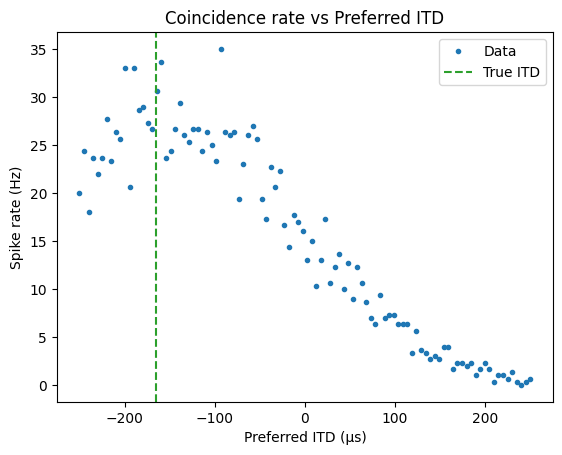

In [28]:
def jeffress_coincidence_spikes_from_sound(
    left_signal: np.ndarray,
    right_signal: np.ndarray,
    sampling_rate: float,
    auditory_arp: float = 0.001,
    preferred_itd: float = 0.0,
    coincidence_window: float = 1e-3,
    jitter_std: float = 100e-6
):
    # filter
    left_filt = bandpass(left_signal, sampling_rate, stim_frequency)
    right_filt = bandpass(right_signal, sampling_rate, stim_frequency)
    # compute l/r spikes
    left_spikes = auditory_nerve_spikes(left_filt, sampling_rate, jitter_std, refractory=auditory_arp)
    right_spikes = auditory_nerve_spikes(right_filt, sampling_rate, jitter_std, refractory=auditory_arp)
    # compute coincidence spikes
    coincidence_spikes = itd_tuned_neuron(left_spikes, right_spikes, delay=preferred_itd, coincidence_window=coincidence_window)
    result = {
        "left_spikes": left_spikes,
        "right_spikes": right_spikes,
        "coincidence_spikes": coincidence_spikes
    }
    return result

sampling_rate = 20000
stim_frequency = 500   #Hz
trial_time = 3.0 # s
angle_deg = -45  
owl_head_width = 0.08  # head width (m)
speed_of_sound = 343.0  # speed of sound (m/s)
itd_domain = np.linspace(-250e-6, 250e-6, 100) 
time_domain = np.arange(0, trial_time, 1/sampling_rate)
sine = np.sin(2 * np.pi * stim_frequency * time_domain)
theta = np.deg2rad(angle_deg)
itd = (owl_head_width / speed_of_sound) * np.sin(theta)  # seconds
print("True ITD:", itd*1e6, "μs")
left_signal = sine.copy()
right_signal = fractional_delay(sine, itd, sampling_rate)

counts = []
for i, delay in enumerate(itd_domain):
    result = jeffress_coincidence_spikes_from_sound(
        left_signal=left_signal,
        right_signal=right_signal,
        sampling_rate=sampling_rate,
        auditory_arp=0.000005,
        preferred_itd=delay,
        coincidence_window=20e-6,
        jitter_std=100e-6
    )
    counts.append(len(result["coincidence_spikes"]))

def fit_gaussian(x, y):
    def gaussian(x, A, x0, sigma):
        return A * np.exp(- (x - x0)**2 / (2 * sigma**2))
    popt, pcov = curve_fit(gaussian, x, y)
    return popt

# plot coincidence rates over range of delays
delays_us = itd_domain * 1e6
rates = np.array(counts) / trial_time
plt.plot(delays_us, rates, "o", markersize=3, label="Data")
plt.xlabel('Preferred ITD (μs)')
plt.ylabel('Spike rate (Hz)')
plt.title("Coincidence rate vs Preferred ITD")
plt.axvline(itd*1e6, color='tab:green', linestyle='--', label="True ITD")
plt.legend()
plt.show()

We can see how well a Gaussian fits the coincidence data. This is not a proper decoder, but it gives us a sense of average model efficacy.

To be clear, the above looks a lot like a tuning curve, but it is not. The x-axis is the preferred ITD, not the ITD of the stimulus.

Next, we can fit a Gaussian to this coincidence rate data and see what the variance is around the fit, which gives a qualitative description of noise in the model.

Gaussian mean: -149.7 μs
Gaussian sigma: 142.6 μs
ITD Error: 15.3 μs
RMS rate spread: 2.39 Hz


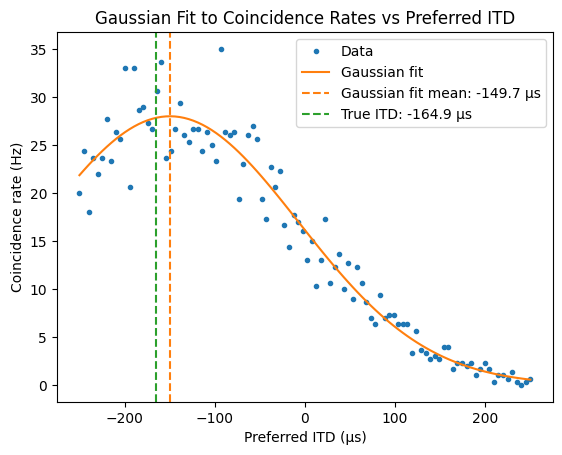

In [29]:
import numpy as np
from scipy.optimize import curve_fit


def fit_gaussian(x, y, constrain_to_x_range=True):
    """
    Fit data to a Gaussian curve with optional constraints.

    Parameters
    ----------
    x : array-like
        Independent variable data
    y : array-like
        Dependent variable data (to be fit)
    constrain_to_x_range : bool, optional
        If True, constrains mean and sigma to the range of x. Default is True.

    Returns
    -------
    params : dict
        Dictionary with fitted parameters: 'amplitude', 'mean', 'sigma'
    fitted_curve : array
        The fitted Gaussian curve evaluated at x
    """

    # Gaussian function
    def gaussian(x, amplitude, mean, sigma):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma**2))

    # Initial guesses
    amplitude_guess = np.max(y)
    mean_guess = x[np.argmax(y)]  # x value at peak y
    sigma_guess = (np.max(x) - np.min(x)) / 4  # Quarter of x range

    p0 = [amplitude_guess, mean_guess, sigma_guess]

    if constrain_to_x_range:
        # Set bounds: mean within x range, sigma between 0 and x range
        x_min, x_max = np.min(x), np.max(x)
        x_range = x_max - x_min

        bounds = (
            [0, x_min, 0],  # Lower bounds: [amp, mean, sigma]
            [np.inf, x_max, x_range],  # Upper bounds
        )

        popt, pcov = curve_fit(gaussian, x, y, p0=p0, bounds=bounds)
    else:
        popt, pcov = curve_fit(gaussian, x, y, p0=p0)

    # Extract parameters
    params = {"amplitude": popt[0], "mean": popt[1], "sigma": popt[2]}

    # Generate fitted curve
    fitted_curve = gaussian(x, *popt)

    return params, fitted_curve

params, fitted = fit_gaussian(delays_us, rates)

print(f"Gaussian mean: {params['mean']:.1f} μs")
print(f"Gaussian sigma: {params['sigma']:.1f} μs")
print(f"ITD Error: {abs(params['mean'] - itd*1e6):.1f} μs")
print(f"RMS rate spread: {np.sqrt(np.mean((rates - fitted) ** 2)):.2f} Hz")

# Plot
plt.plot(delays_us, rates, "o", markersize=3, label="Data")
plt.plot(delays_us, fitted, "-", label="Gaussian fit")
plt.xlabel("Preferred ITD (μs)")
plt.ylabel("Coincidence rate (Hz)")
plt.axvline(params['mean'], color='tab:orange', linestyle='--', label=f"Gaussian fit mean: {params['mean']:.1f} μs")
plt.axvline(itd*1e6, color='tab:green', linestyle='--', label=f"True ITD: {itd*1e6:.1f} μs")
plt.legend()
plt.title("Gaussian Fit to Coincidence Rates vs Preferred ITD")
plt.show()

Next, we can compute the actual tuning curve by fixing a preferred ITD and varying the anglular coordinate of the sound source.

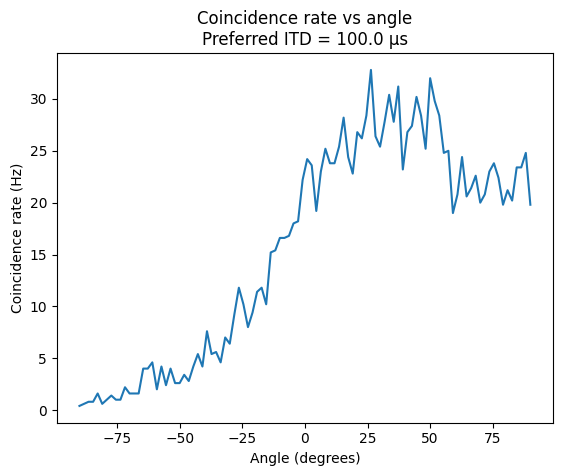

In [33]:
# generate signals
n_angles = 100
angle_domain_deg = np.linspace(-90, 90, n_angles)

sampling_rate = 20000
stim_frequency = 1000  # Hz
trial_time = 5.0  # s
owl_head_width = 0.08  # head width (m)
speed_of_sound = 343.0  # speed of sound (m/s)
preferred_itd = 100  # preferred ITD (µs)
jitter_std = 1  # jitter standard deviation (µs)
time_domain = np.arange(0, trial_time, 1 / sampling_rate)
sine = np.sin(2 * np.pi * stim_frequency * time_domain)

signal_array = np.zeros((len(angle_domain_deg), len(time_domain), 2))
for i, angle in enumerate(angle_domain_deg):
    itd = (owl_head_width / speed_of_sound) * np.sin(np.deg2rad(angle))  # seconds
    left_signal = sine.copy()
    right_signal = fractional_delay(sine, itd, sampling_rate)
    signal_array[i, :, 0] = left_signal
    signal_array[i, :, 1] = right_signal

spike_times = []
counts = []
for i, angle in enumerate(angle_domain_deg):
    result = jeffress_coincidence_spikes_from_sound(
        left_signal=signal_array[i, :, 0],
        right_signal=signal_array[i, :, 1],
        sampling_rate=sampling_rate,
        auditory_arp=1e-6,
        preferred_itd=preferred_itd * 1e-6,
        coincidence_window=10e-6,
        jitter_std=jitter_std * 1e-6,
    )
    spike_times.append(result['coincidence_spikes'])
    counts.append(len(result['coincidence_spikes']))

rates = np.array(counts) / trial_time
plt.figure()
plt.plot(angle_domain_deg, rates)
plt.xlabel("Angle (degrees)")
plt.ylabel("Coincidence rate (Hz)")
plt.title(f"Coincidence rate vs angle\nPreferred ITD = {preferred_itd:.1f} µs")
plt.show()

The above plot shows the tuning curve for the auditory coincidence detector over a range of incident angles. 

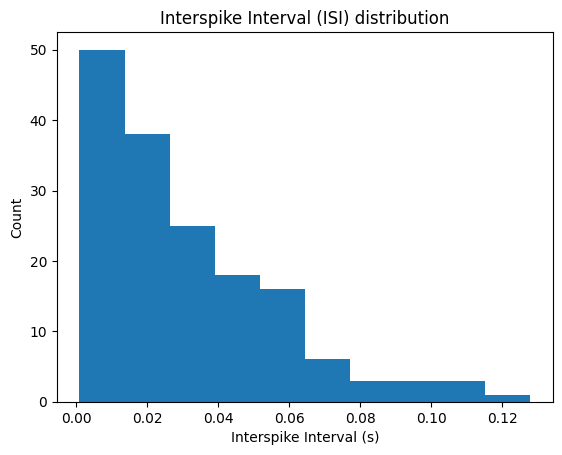

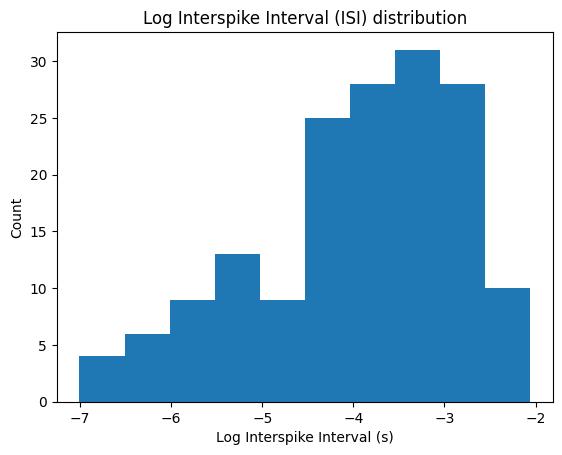

In [ ]:
# plot interspike interval histogram for one trial

most_spikes_idx = np.argmax([len(spike_times[i]) for i in range(len(spike_times))])
isi = np.diff(spike_times[most_spikes_idx])
plt.hist(isi, bins=10)
plt.xlabel('Interspike Interval (s)')
plt.ylabel('Count')
plt.title('Interspike Interval (ISI) distribution')
plt.show()

plt.hist(np.log(isi), bins=10)
plt.xlabel('Log Interspike Interval (s)')
plt.ylabel('Count')
plt.title('Log Interspike Interval (ISI) distribution')
plt.show()


